## 1. EDA

In [1]:
# Lets see if CUDA is available
import tensorflow as tf

if tf.test.is_built_with_cuda():
    print("TensorFlow was built with CUDA")
else:
    print("TensorFlow was not built with CUDA")

print("GPUs available: ", tf.config.list_physical_devices('GPU'))

TensorFlow was built with CUDA
GPUs available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# extract the zip, photos and csv
import zipfile
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

zip_file_path = './sports.zip'
extract_to_directory = './sports_dataset'

os.makedirs(extract_to_directory, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_directory)

print(f'Archivos extraídos en: {extract_to_directory}')

Archivos extraídos en: ./sports_dataset


In [3]:
import pandas as pd
# Using sports csv
df = pd.read_csv('./sports_dataset/sports.csv')

df.head()

,class id,filepaths,labels,data set
0,0,train/air hockey/001.jpg,air hockey,train
1,0,train/air hockey/002.jpg,air hockey,train
2,0,train/air hockey/003.jpg,air hockey,train
3,0,train/air hockey/004.jpg,air hockey,train
4,0,train/air hockey/005.jpg,air hockey,train


Lets start to make an EDA about this dataset, lets see how many nulls or nans, numbr of rows and columns...  

In [4]:
df.isnull().sum()

class id     0
filepaths    0
labels       0
data set     0
dtype: int64

In [5]:
df.isna().sum()

class id     0
filepaths    0
labels       0
data set     0
dtype: int64

In [6]:
df.describe()

,class id
count,14493.000000
mean,49.206375
std,28.357108
min,0.000000
25%,25.000000
50%,49.000000
75%,73.000000
max,99.000000


In [7]:
df.shape

(14493, 4)

In [8]:
df[0:0]

,class id,filepaths,labels,data set


In [9]:
for column in df.select_dtypes(include=['object']).columns:
    print(f"Frecuency per column {column}:")
    print(df[column].value_counts())
    print("\n")

Frecuency per column filepaths:
filepaths
train/air hockey/001.jpg       1
train/rowing/090.jpg           1
train/rowing/064.jpg           1
train/rowing/065.jpg           1
train/rowing/066.jpg           1
                              ..
train/giant slalom/070.jpg     1
train/giant slalom/071.jpg     1
train/giant slalom/072.jpg     1
train/giant slalom/073.jpg     1
valid/wingsuit flying/5.jpg    1
Name: count, Length: 14493, dtype: int64


Frecuency per column labels:
labels
football              201
formula 1 racing      200
nascar racing         199
baseball              184
hockey                182
                     ... 
horseshoe pitching    112
arm wrestling         109
wingsuit flying       108
ultimate              107
sky surfing            69
Name: count, Length: 100, dtype: int64


Frecuency per column data set:
data set
train    13493
test       500
valid      500
Name: count, dtype: int64




So we had 13493 photos for train, 500 for test and 500 for validation

C:\Users\carlo\AppData\Local\Temp\ipykernel_5164\2072939675.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


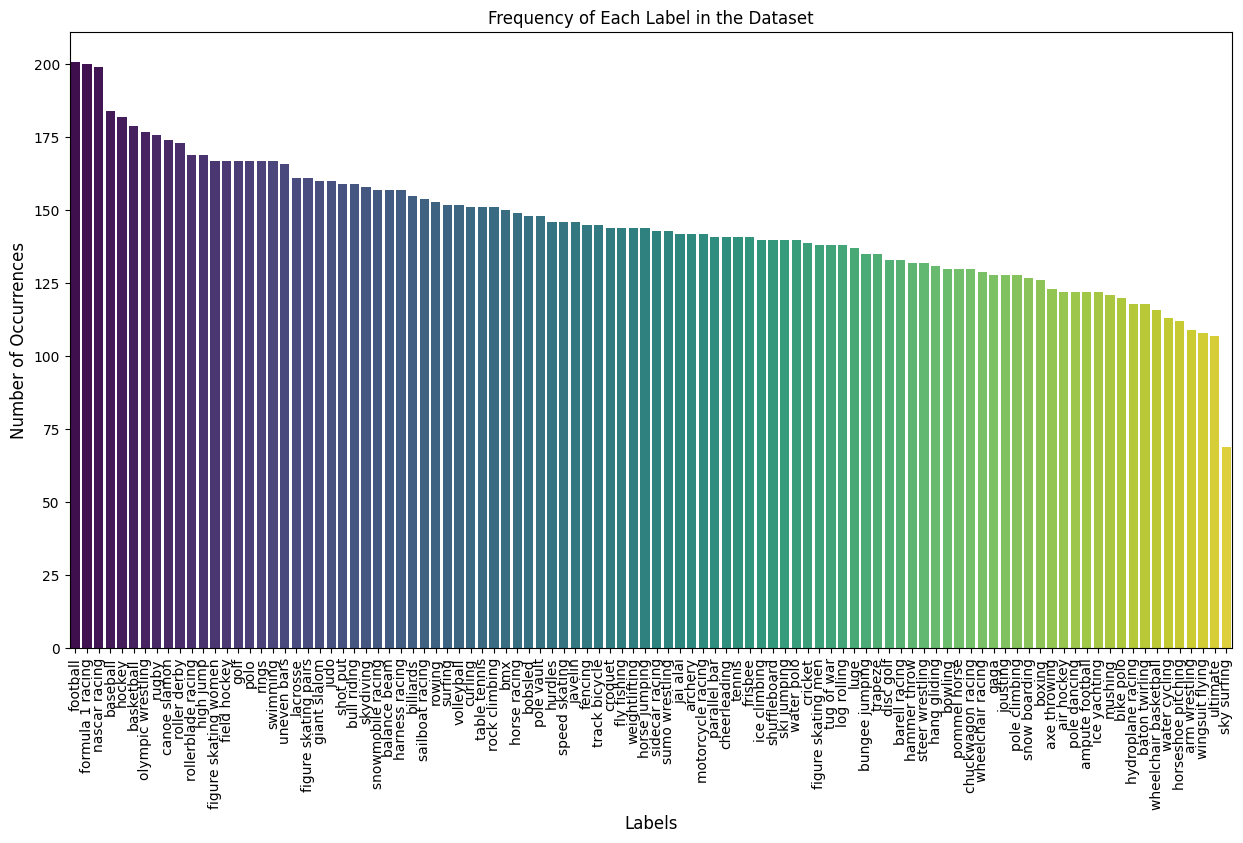

In [10]:
label_counts = df['labels'].value_counts()

plt.figure(figsize=(15,8))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title('Frequency of Each Label in the Dataset')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Labels', fontsize=12)
plt.xticks(rotation=90)
plt.show()

More or less, the average number of photos for each sport is 140, but we have football with 201 and skysurfing with 69, which means we should probably use data augmentation.

Now lets take a look to the photos:

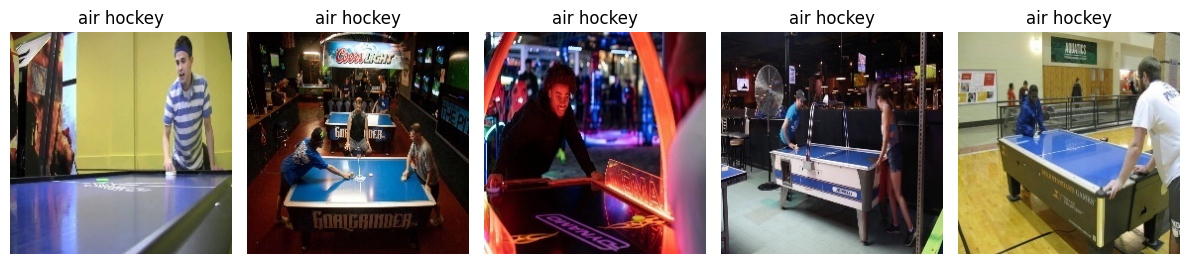

In [11]:
def load_and_show_images(data, num_images=4):
    plt.figure(figsize=(12, 8))

    for i in range(num_images):
        # Load the image
        image_path = os.path.join('./sports_dataset/', data.iloc[i]['filepaths'])
        image = Image.open(image_path)

        # Show the image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(data.iloc[i]['labels'])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

load_and_show_images(df,5)

In [12]:
def count_image_types(filepaths):
    # Inicializar contadores
    count_valid = 0
    count_invalid = 0
    valid_extensions = ('.png', '.jpg', '.jpeg')

    # Contar archivos
    for filepath in filepaths:
        if filepath.lower().endswith(valid_extensions):
            count_valid += 1
        else:
            count_invalid += 1

    return count_valid, count_invalid

count_image_types(df['filepaths'])

(14492, 1)

there is 1 image that has none a valid format, lets delete it

In [13]:
valid_extensions = ('.png', '.jpg', '.jpeg')

# Filtrar el DataFrame para mantener solo las filas con extensiones de archivo válidas
df = df[df['filepaths'].str.lower().str.endswith(valid_extensions)]
count_image_types(df['filepaths'])

(14492, 0)

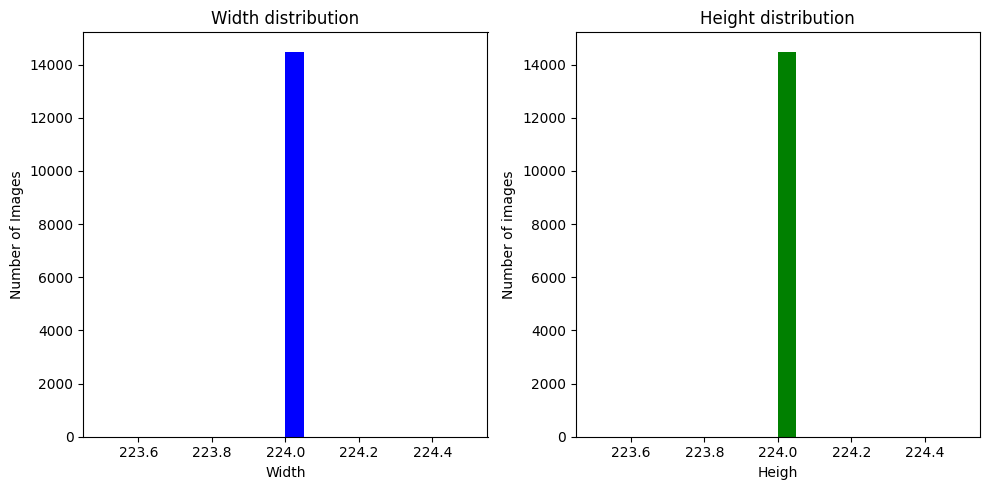

In [14]:
# lets see if the image has differents dimensions
widths = []
heights = []

for filepath in df['filepaths']:
    image_path = os.path.join('./sports_dataset/', filepath)
    image = Image.open(image_path)
    width, height = image.size
    widths.append(width)
    heights.append(height)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(widths, bins=20, color='blue')
plt.title('Width distribution')
plt.xlabel('Width')
plt.ylabel('Number of Images')

plt.subplot(1, 2, 2)
plt.hist(heights, bins=20, color='green')
plt.title('Height distribution')
plt.xlabel('Heigh')
plt.ylabel('Number of images')

plt.tight_layout()
plt.show()

In [15]:
import numpy as np
pixels_r = []
pixels_g = []
pixels_b = []

# needs a lot of ram and free colab has not enought
"""
for filepath in df['filepaths']:
    image_path = os.path.join('./sports_dataset/', filepath)
    image = Image.open(image_path)
    pixels = np.array(image)

    if len(pixels.shape) == 3:
        r, g, b = pixels[:,:,0], pixels[:,:,1], pixels[:,:,2]
        pixels_r.extend(r.flatten())
        pixels_g.extend(g.flatten())
        pixels_b.extend(b.flatten())

plt.figure(figsize=(10, 5))
sns.kdeplot(pixels_r, color="red", shade=True, label="Rojo")
sns.kdeplot(pixels_g, color="green", shade=True, label="Verde")
sns.kdeplot(pixels_b, color="blue", shade=True, label="Azul")
plt.title('Distribución de Intensidades de Píxeles por Canal RGB')
plt.xlabel('Intensidad de Píxeles')
plt.ylabel('Densidad')
plt.legend()
plt.show()
"""

'\nfor filepath in df[\'filepaths\']:\n    image_path = os.path.join(\'./sports_dataset/\', filepath)\n    image = Image.open(image_path)\n    pixels = np.array(image)\n\n    if len(pixels.shape) == 3:\n        r, g, b = pixels[:,:,0], pixels[:,:,1], pixels[:,:,2]\n        pixels_r.extend(r.flatten())\n        pixels_g.extend(g.flatten())\n        pixels_b.extend(b.flatten())\n\nplt.figure(figsize=(10, 5))\nsns.kdeplot(pixels_r, color="red", shade=True, label="Rojo")\nsns.kdeplot(pixels_g, color="green", shade=True, label="Verde")\nsns.kdeplot(pixels_b, color="blue", shade=True, label="Azul")\nplt.title(\'Distribución de Intensidades de Píxeles por Canal RGB\')\nplt.xlabel(\'Intensidad de Píxeles\')\nplt.ylabel(\'Densidad\')\nplt.legend()\nplt.show()\n'

Those images are 224x224 in RGB, maybe we should use colors and not grayscale such as some sports as football should have more green that surf as example

## 2. Preprocessing

With that short EDA, we can have an idea about what we are going to need and use

In [16]:
# generate the 3 datasets
train_df= df[df["data set"] == "train"]
test_df = df[df["data set"] == "test"]
val_df = df[df["data set"] == "validation"]

train_df #there should be only 13492 rows

,class id,filepaths,labels,data set
0,0,train/air hockey/001.jpg,air hockey,train
1,0,train/air hockey/002.jpg,air hockey,train
2,0,train/air hockey/003.jpg,air hockey,train
3,0,train/air hockey/004.jpg,air hockey,train
4,0,train/air hockey/005.jpg,air hockey,train
...,...,...,...,...
13488,99,train/wingsuit flying/94.jpg,wingsuit flying,train
13489,99,train/wingsuit flying/95.jpg,wingsuit flying,train
13490,99,train/wingsuit flying/96.jpg,wingsuit flying,train
13491,99,train/wingsuit flying/97.jpg,wingsuit flying,train


preprocessing of the image, we will use 120x120x3 as sice, and normalice them

In [20]:
import tensorflow as tf

def load_and_preprocess_image(filepath, label):
    def load_image(filepath):
        # tf.io.read_file espera una ruta de archivo como un string de Python, no un Tensor.
        return tf.io.read_file(filepath.numpy())

    # Usar tf.py_function para envolver la función de carga de imágenes
    img = tf.py_function(load_image, [filepath], tf.string)
    # use the same decode and RGB
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image
    img = tf.image.resize(img, [130, 130])
    # normalize
    img = tf.cast(img, tf.float32) / 255.0
    
    # data augmentation
    img = tf.image.random_flip_left_right(img) 
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, lower=0.9, upper=1.1)
    
    return img, label

def load_and_preprocess_image_no_aug(filepath, label):
    def load_image(filepath):
        # tf.io.read_file espera una ruta de archivo como un string de Python, no un Tensor.
        return tf.io.read_file(filepath.numpy())

    # Usar tf.py_function para envolver la función de carga de imágenes
    img = tf.py_function(load_image, [filepath], tf.string)
    # use the same decode and RGB
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image
    img = tf.image.resize(img, [130, 130])
    # normalize
    img = tf.cast(img, tf.float32) / 255.0
    
    return img, label


create the dataset

In [21]:
def df_to_dataset(df, shuffle=True, batch_size=32, aug=True):
    base_image_path = './sports_dataset'
    filepaths = df['filepaths'].apply(lambda x: os.path.join(base_image_path, x)).tolist()
    labels = df['class id'].tolist()

    # Create the dataset with the image and labels
    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))

    # load imagesn and
    if aug:
        dataset_1 = dataset.map(load_and_preprocess_image)
        dataset_2 = dataset.map(load_and_preprocess_image_no_aug)
        dataset = dataset_1.concatenate(dataset_2)
    else:
        dataset = dataset.map(load_and_preprocess_image_no_aug)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(filepaths))

    dataset.concatenate
    # Batch y prefetch
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

batch_size = 64

train_dataset = df_to_dataset(train_df, shuffle=True, batch_size=batch_size)
validation_dataset = df_to_dataset(val_df, shuffle=False, batch_size=batch_size, aug=False)
test_dataset = df_to_dataset(test_df, shuffle=False, batch_size=batch_size, aug=False)

take a look to the images after being preprocessed

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

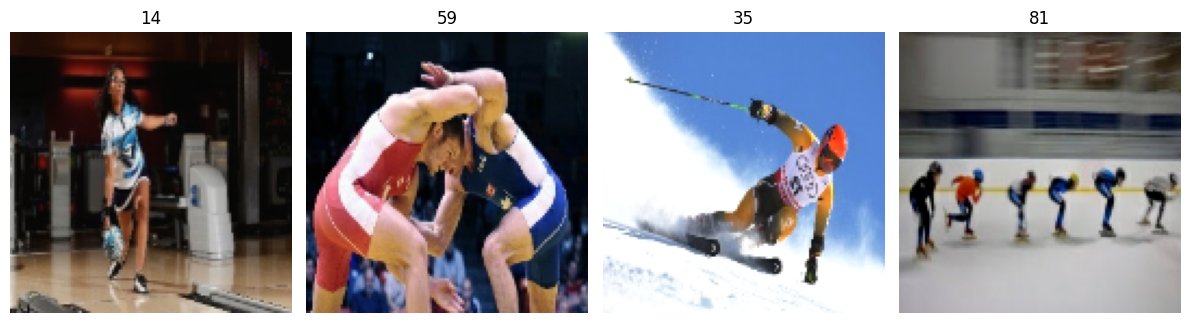

In [22]:
import matplotlib.pyplot as plt

def show_images(dataset, num_images=4):
    plt.figure(figsize=(12, 8))

    for images, labels in dataset.take(num_images):
        for i in range(num_images):
            img = images[i].numpy()
            label = labels[i].numpy()

            plt.subplot(1, num_images, i + 1)
            plt.imshow(img)
            plt.title(label)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

show_images(train_dataset, 4)


## 3. Create the model
---


In [27]:
from re import L
import tensorflow.keras.models as models
from tensorflow.keras import regularizers

def create_model(num_clases, num_dense=120, activ_conv='relu',
                 activ_dense='softmax', padding='valid', l2_value=0.01):
  return tf.keras.models.Sequential([
    #conv-pool
    tf.keras.layers.Conv2D(filters=150, kernel_size=(3, 3), input_shape=(130, 130, 3), kernel_regularizer=tf.keras.regularizers.l1(l2_value)),
    tf.keras.layers.BatchNormalization(),  # Añadir Batch Normalization
    tf.keras.layers.Activation(activ_conv),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding=padding),
    
    tf.keras.layers.Conv2D(filters=150, kernel_size=(5, 5), kernel_regularizer=tf.keras.regularizers.l2(l2_value)),
    tf.keras.layers.BatchNormalization(),  # Añadir Batch Normalization
    tf.keras.layers.Activation(activ_conv),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding=padding),
    # conv-pool
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_clases, activation='softmax')
])

## 4. Train Test model
---

In [28]:
##Generar los modelos
from sklearn.model_selection import learning_curve
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD,Adam

#model_1 = create_model(120, num_dense=200, activ_conv='relu',
#                 activ_dense='relu', padding='same')
file_path = 'best_model_1.keras'
#if os.path.isfile(file_path):
#  print("Cargando modelo")
#  model_1 = tf.keras.models.load_model(file_path)
#else:
print("Creando modelo")
model_1 = create_model(100, num_dense=90, activ_conv='relu',
                    activ_dense='softmax', padding='same', l2_value=0.001)
print(model_1.summary())
## optimizer, usamos descendiente del gradiente
# al aumentar o disminuir momentum dependeremos mas o menos de los gradientes
# calculados anteriormente para el proximo salto (actualizacion de pesos)
optimizer_a = SGD(learning_rate=0.001, momentum=0.9)
#optimizer_a = Adam(learning_rate=0.0001)
# ya use el AdmaW optimizer, pero me funciona peor para este caso que SGD

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=11,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1,
    min_lr=0.00000001
)

model_1.compile(
    optimizer=optimizer_a,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint_1 = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max' )

## Entrenar los modelos, se guarda el mejor resultado hasta el momento
num_epochs = 100

history_1 = model_1.fit(train_dataset, epochs=num_epochs, batch_size=batch_size,
                        verbose=1, validation_data=(test_dataset),
                        callbacks=[checkpoint_1, early_stopping, reduce_lr])

Creando modelo
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 150)     4200      
                                                                 
 batch_normalization_4 (Batc  (None, 128, 128, 150)    600       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 128, 128, 150)     0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 150)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 150)       562650    
                                                                 
 batch_normalization_5 (Batc  (None, 60

KeyboardInterrupt: 